In [1]:
# CREAMOS LOS CONJUNTOS DE ENTRENAMIENTO Y TEST
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(25)

inEnglish=True
crearNuevoConjunto=False

# Tomando 1:positivo, 0:neutro, -1:negativo
sujeto   = ['turista','estudiante','familia']
pol_suj  = [0,0,1]
verbo    = ['visita','disfruta','recomienda','entra','critica']
pol_ver  = [1,1,1,0,-1]
objeto   = ['mina','museo','fábrica','paisaje','cueva','ruta','tren']
pol_obj  = [0,0,0,0,0,0,0]
adjetivo = ['abandonado','interesante','impresionante','aburrido','desagradable','abierto']
pol_adj  = [-1,1,1,-1,-1,0]

if inEnglish:
    sujeto   = ['tourist','student','family']
    verbo    = ['visits','enjoys','recommends','enters','criticizes']
    objeto   = ['mine','museum','factory','landscape','cave','route','train']
    adjetivo = ['abandoned','interesting','impressive','boring','disgusting','open']
    
if crearNuevoConjunto:
    conjunto_entrenamiento = []
    for s in range(len(sujeto)):
        for v in range(len(verbo)):
            for o in range(len(objeto)):
                for a in range(len(adjetivo)):
                    suma = pol_suj[s]+pol_ver[v]+pol_obj[o]+pol_adj[a]
                    if suma>0.01: polaridad = 1
                    elif suma<-0.01: polaridad = -1
                    else: polaridad = 0 
                    frase = sujeto[s] + ' ' + verbo[v] + ' ' + objeto[o] + ' ' + adjetivo[a]
                    if inEnglish: frase = sujeto[s] + ' ' + verbo[v] + ' ' + adjetivo[a] + ' ' + objeto[o] 
                    conjunto_entrenamiento.append((frase, polaridad))
    
    conjunto = pd.DataFrame(conjunto_entrenamiento, columns=['frase', 'polaridad'])
    conjunto.to_csv('conjunto_individuales.csv', index=False)
    
    # seleccionamos frases positivas y negativas
    N = 100 # Numero de frases de cada tipo
    positivos = conjunto.loc[conjunto['polaridad']==1]
    negativos = conjunto.loc[conjunto['polaridad']==-1]
    
    positivos = positivos.sample(N)
    negativos = negativos.sample(N)
    todos = pd.concat([positivos,negativos])
    frases = todos.to_numpy()
    
    conjunto_nuevo = []
    while len(conjunto_nuevo)<700:
        i,j=np.random.choice(np.arange(0,2*N),size=2,replace=False).tolist()
        frase1 = frases[i][0]
        pol1 = frases[i][1]
        frase2 = frases[j][0]
        pol2 = frases[j][1]
        if np.sign(pol1)==np.sign(pol2): pol3=1
        else: pol3=0
        linea = (frase1+str(' .'),frase2+str(' .'),str(pol3))
        conjunto_nuevo.append((frase1+str(' .'),frase2+str(' .'),str(pol3)))
    
    conjunto2 = pd.DataFrame(conjunto_nuevo)
    conjunto2.to_csv('conjunto_parejas.csv', index=False,header=False)
    
    train, testsplit = train_test_split(conjunto2, test_size=400/700)
    test, dev = train_test_split(testsplit, test_size=0.5)

    todos.to_csv('frases_individuales.csv', index=False,header=False)
    train.to_csv('mc_pair_train_data.csv', index=False,header=False)
    test.to_csv('mc_pair_test_data.csv', index=False,header=False)
    dev.to_csv('mc_pair_dev_data.csv', index=False,header=False)

In [2]:
import torch
import random

SEED = 12
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            line = line.split(',')
            labels.append(int(line[2]))
            sentences.append((line[0], line[1]))
    return labels, sentences

train_labels, train_data = read_data('mc_pair_train_data.csv')
dev_labels, dev_data = read_data('mc_pair_dev_data.csv')
test_labels, test_data = read_data('mc_pair_test_data.csv')

In [4]:
train_data_l, train_data_r = zip(*train_data)
train_data_unpaired = list(train_data_l) + list(train_data_r)
dev_data_l, dev_data_r = zip(*dev_data)
dev_data_unpaired = list(dev_data_l) + list(dev_data_r)
test_data_l, test_data_r = zip(*test_data)
test_data_unpaired = list(test_data_l) + list(test_data_r)

In [5]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data_unpaired)
raw_dev_diagrams = reader.sentences2diagrams(dev_data_unpaired)
raw_test_diagrams = reader.sentences2diagrams(test_data_unpaired)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


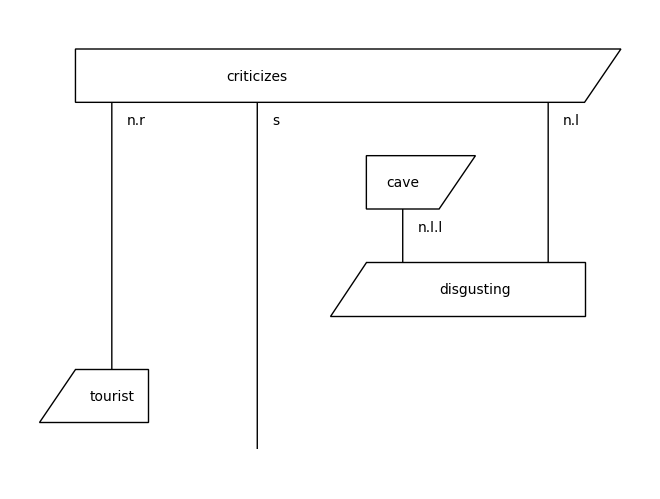

In [6]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[1].draw()

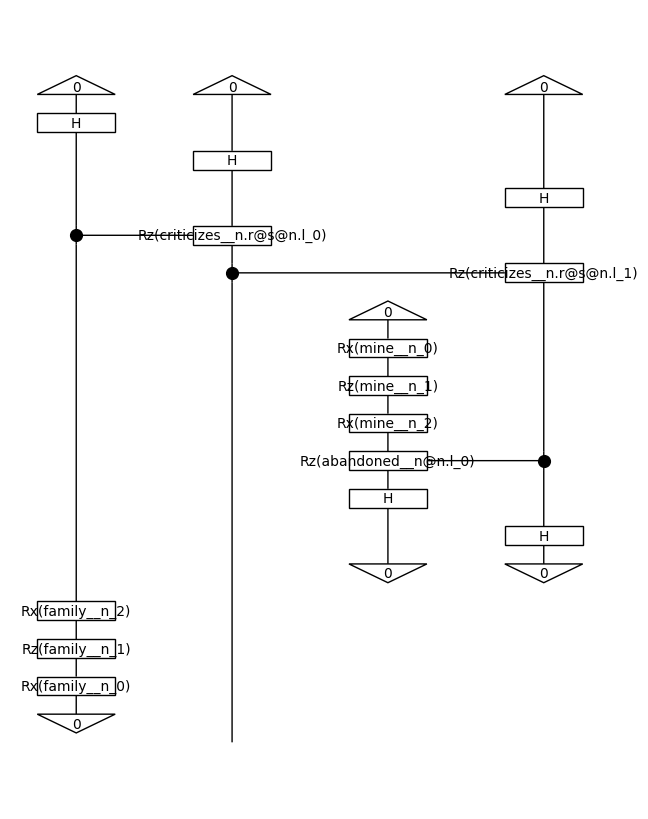

In [7]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [59]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

In [60]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.xor_net = nn.Sequential(nn.Linear(4, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 1),
                                     nn.Sigmoid())

    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        # evaluate each circuit and concatenate the results
        evaluated_pairs = torch.cat((self.get_diagram_output(first_d),
                                     self.get_diagram_output(second_d)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        # pass the concatenated results through a simple neural network
        return self.xor_net(evaluated_pairs)

In [61]:
def make_pair_data(diagrams):
    pair_diags = list(zip(diagrams[:len(diagrams)//2], diagrams[len(diagrams)//2:]))
    return pair_diags

train_pair_circuits = make_pair_data(train_circuits)
dev_pair_circuits = make_pair_data(dev_circuits)
test_pair_circuits = make_pair_data(test_circuits)

In [62]:
from lambeq import Dataset

all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

# initialise our model by passing in the diagrams, so that we have trainable parameters for each token
model = XORSentenceModel.from_diagrams(a + b, probabilities=True, normalize=True)
model.initialise_weights()
model = model.double()

# initialise datasets and optimizers as in PyTorch
train_pair_dataset = Dataset(train_pair_circuits,
                             train_labels,
                             batch_size=BATCH_SIZE)

test_pair_dataset = Dataset(test_pair_circuits,
                             test_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [63]:
from timeit import default_timer as timer

def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.DoubleTensor(labels)).sum().item()/len(circs)

best = {'acc': 0, 'epoch': 0}
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []


tstart=timer()
for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)

        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(epoch_loss)

    epoch_loss_test=0
    for circuits, labels in test_pair_dataset:
        predicted = model(circuits)
        loss_test = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss_test += loss_test.item()
    test_losses.append(epoch_loss_test)

    train_accuracy.append(accuracy(train_pair_circuits, train_labels))
    test_accuracy.append(accuracy(test_pair_circuits, test_labels))
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('xor_model.lt')
        elif i - best['epoch'] >= 15:
            stop_epoch = best['epoch']
            print('Early stopping')
            break
tend=timer()

if best['acc'] > accuracy(dev_pair_circuits, dev_labels):
    model.load('xor_model.lt')
    model = model.double()

print('\nFinal test accuracy: {}'.format(accuracy(test_pair_circuits, test_labels)))
print('Tiempo de entrenamiento:',tend-tstart,'segundos.')

Epoch: 0
Train loss: 4.244820085159552
Dev acc: 0.54
Epoch: 5
Train loss: 4.006205433536699
Dev acc: 0.645
Epoch: 10
Train loss: 3.469491440470371
Dev acc: 0.79
Epoch: 15
Train loss: 3.094672523277554
Dev acc: 0.78
Epoch: 20
Train loss: 1.9531867997156998
Dev acc: 0.975
Epoch: 25
Train loss: 1.2651855992952674
Dev acc: 0.995
Epoch: 30
Train loss: 0.7215679359175969
Dev acc: 0.975
Epoch: 35
Train loss: 0.5909141157116127
Dev acc: 0.91
Epoch: 40
Train loss: 4.594871867316564
Dev acc: 0.7
Early stopping

Final test accuracy: 0.99
Tiempo de entrenamiento: 508.6440956000001 segundos.


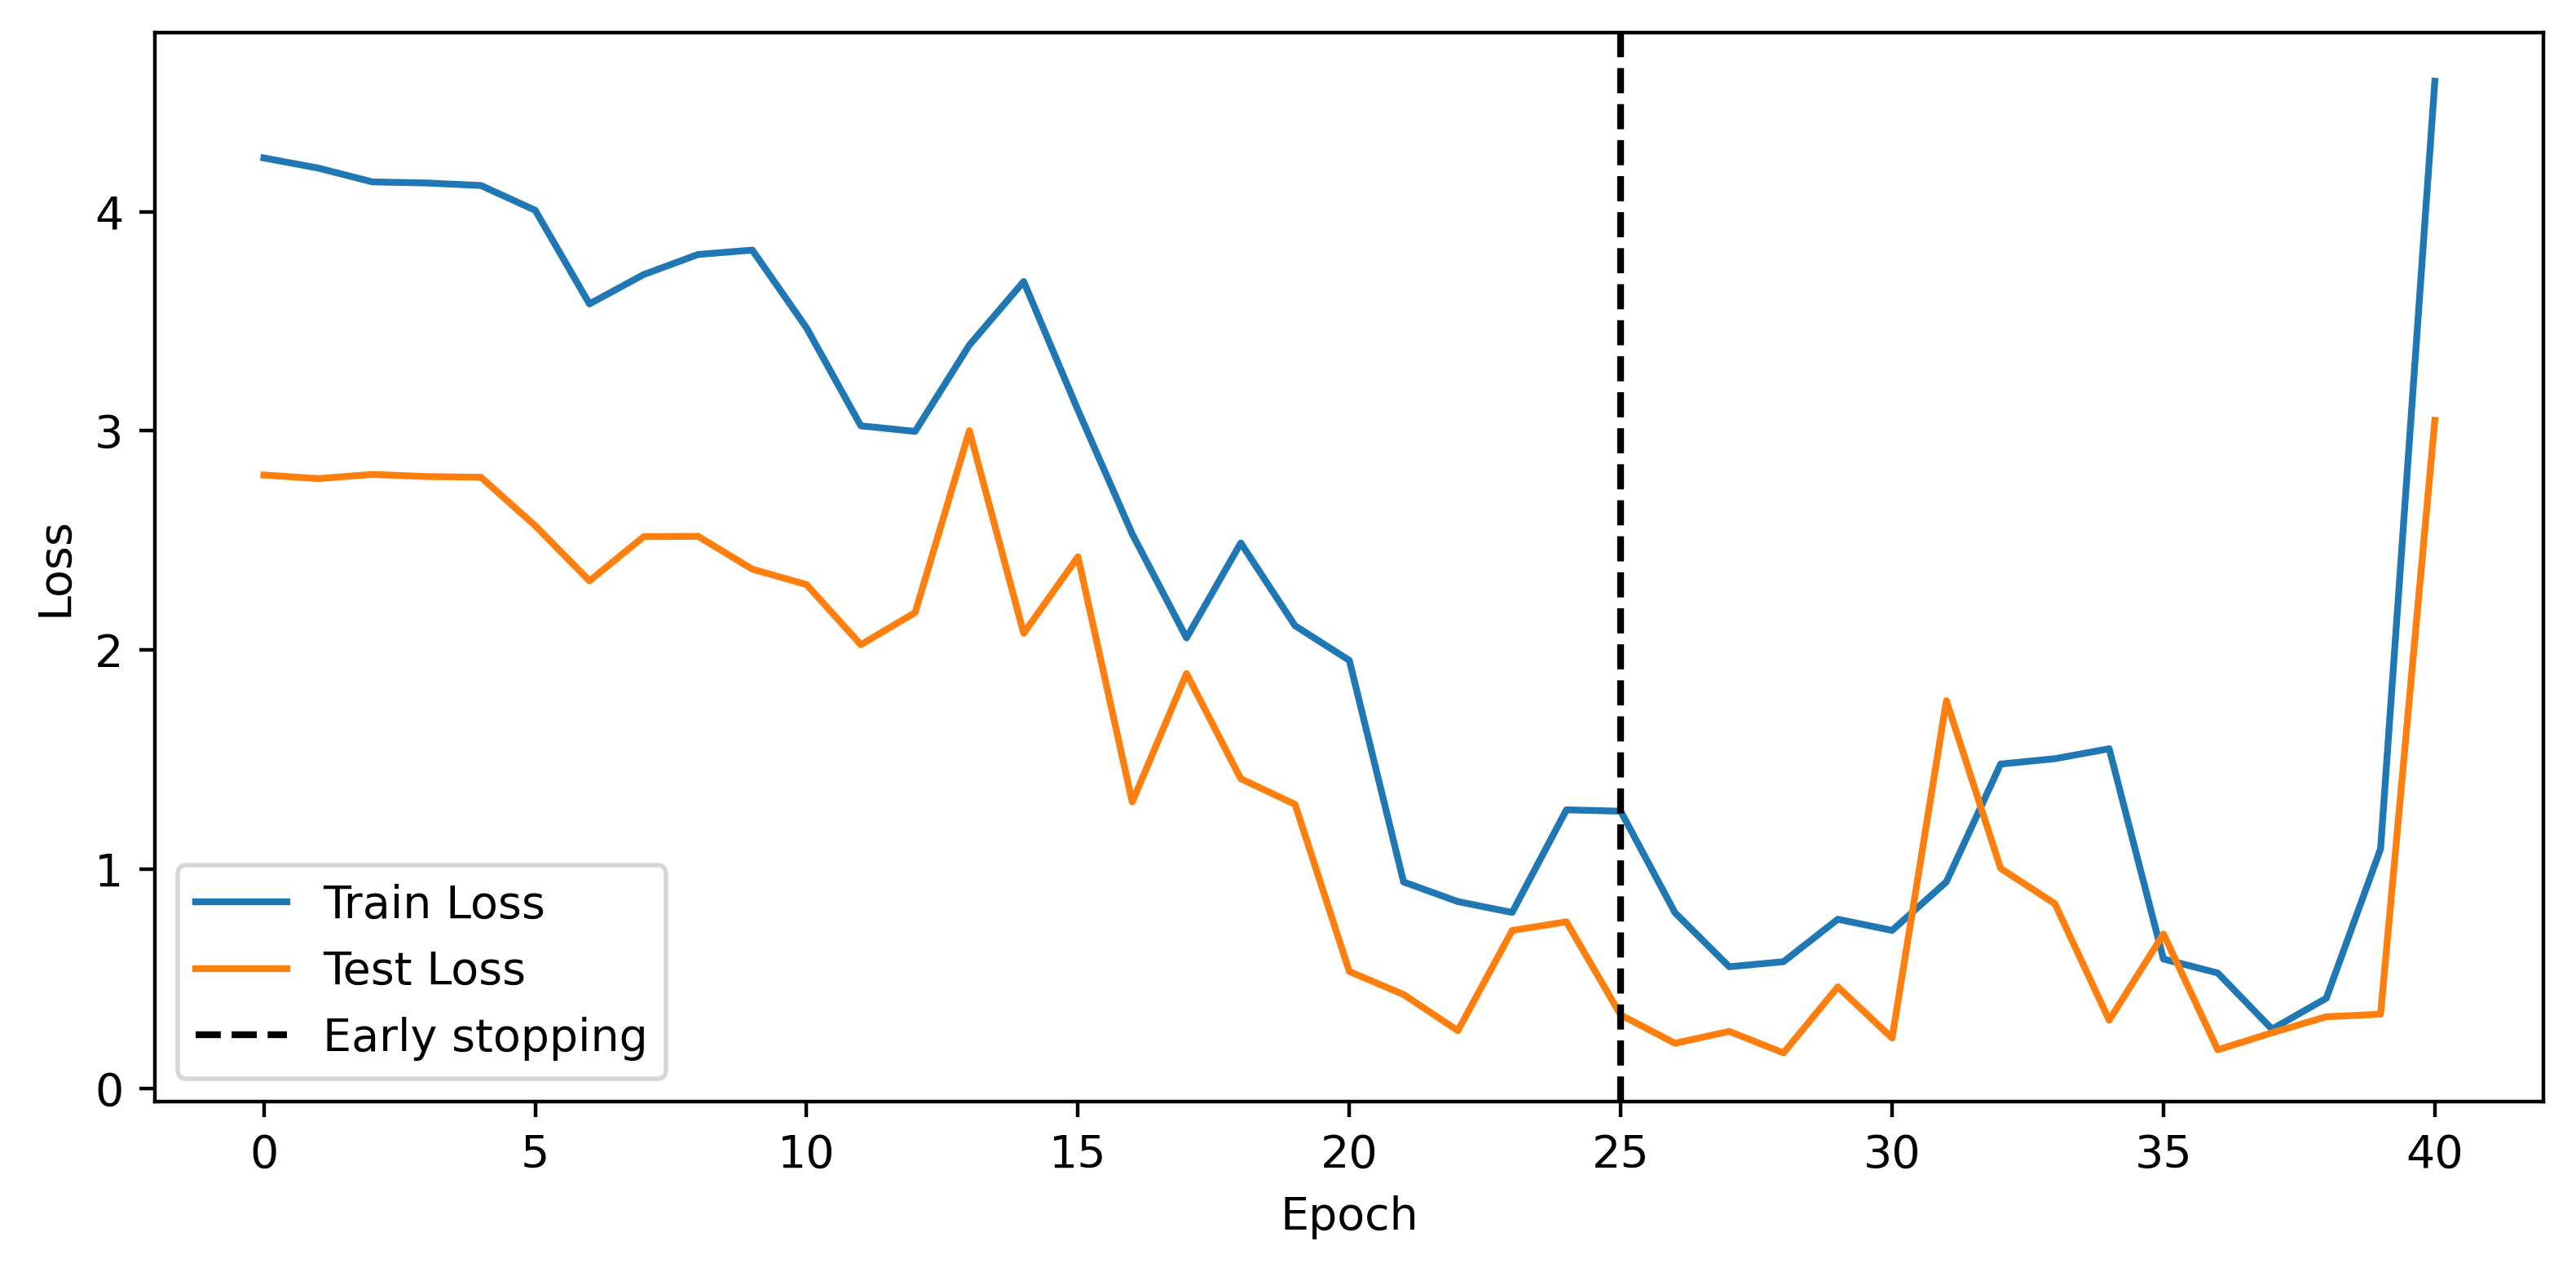

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4),dpi=400)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.axvline(stop_epoch,ls='--',color='black',label='Early stopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('ClasificadorBinarioLoss.pdf')
plt.show()

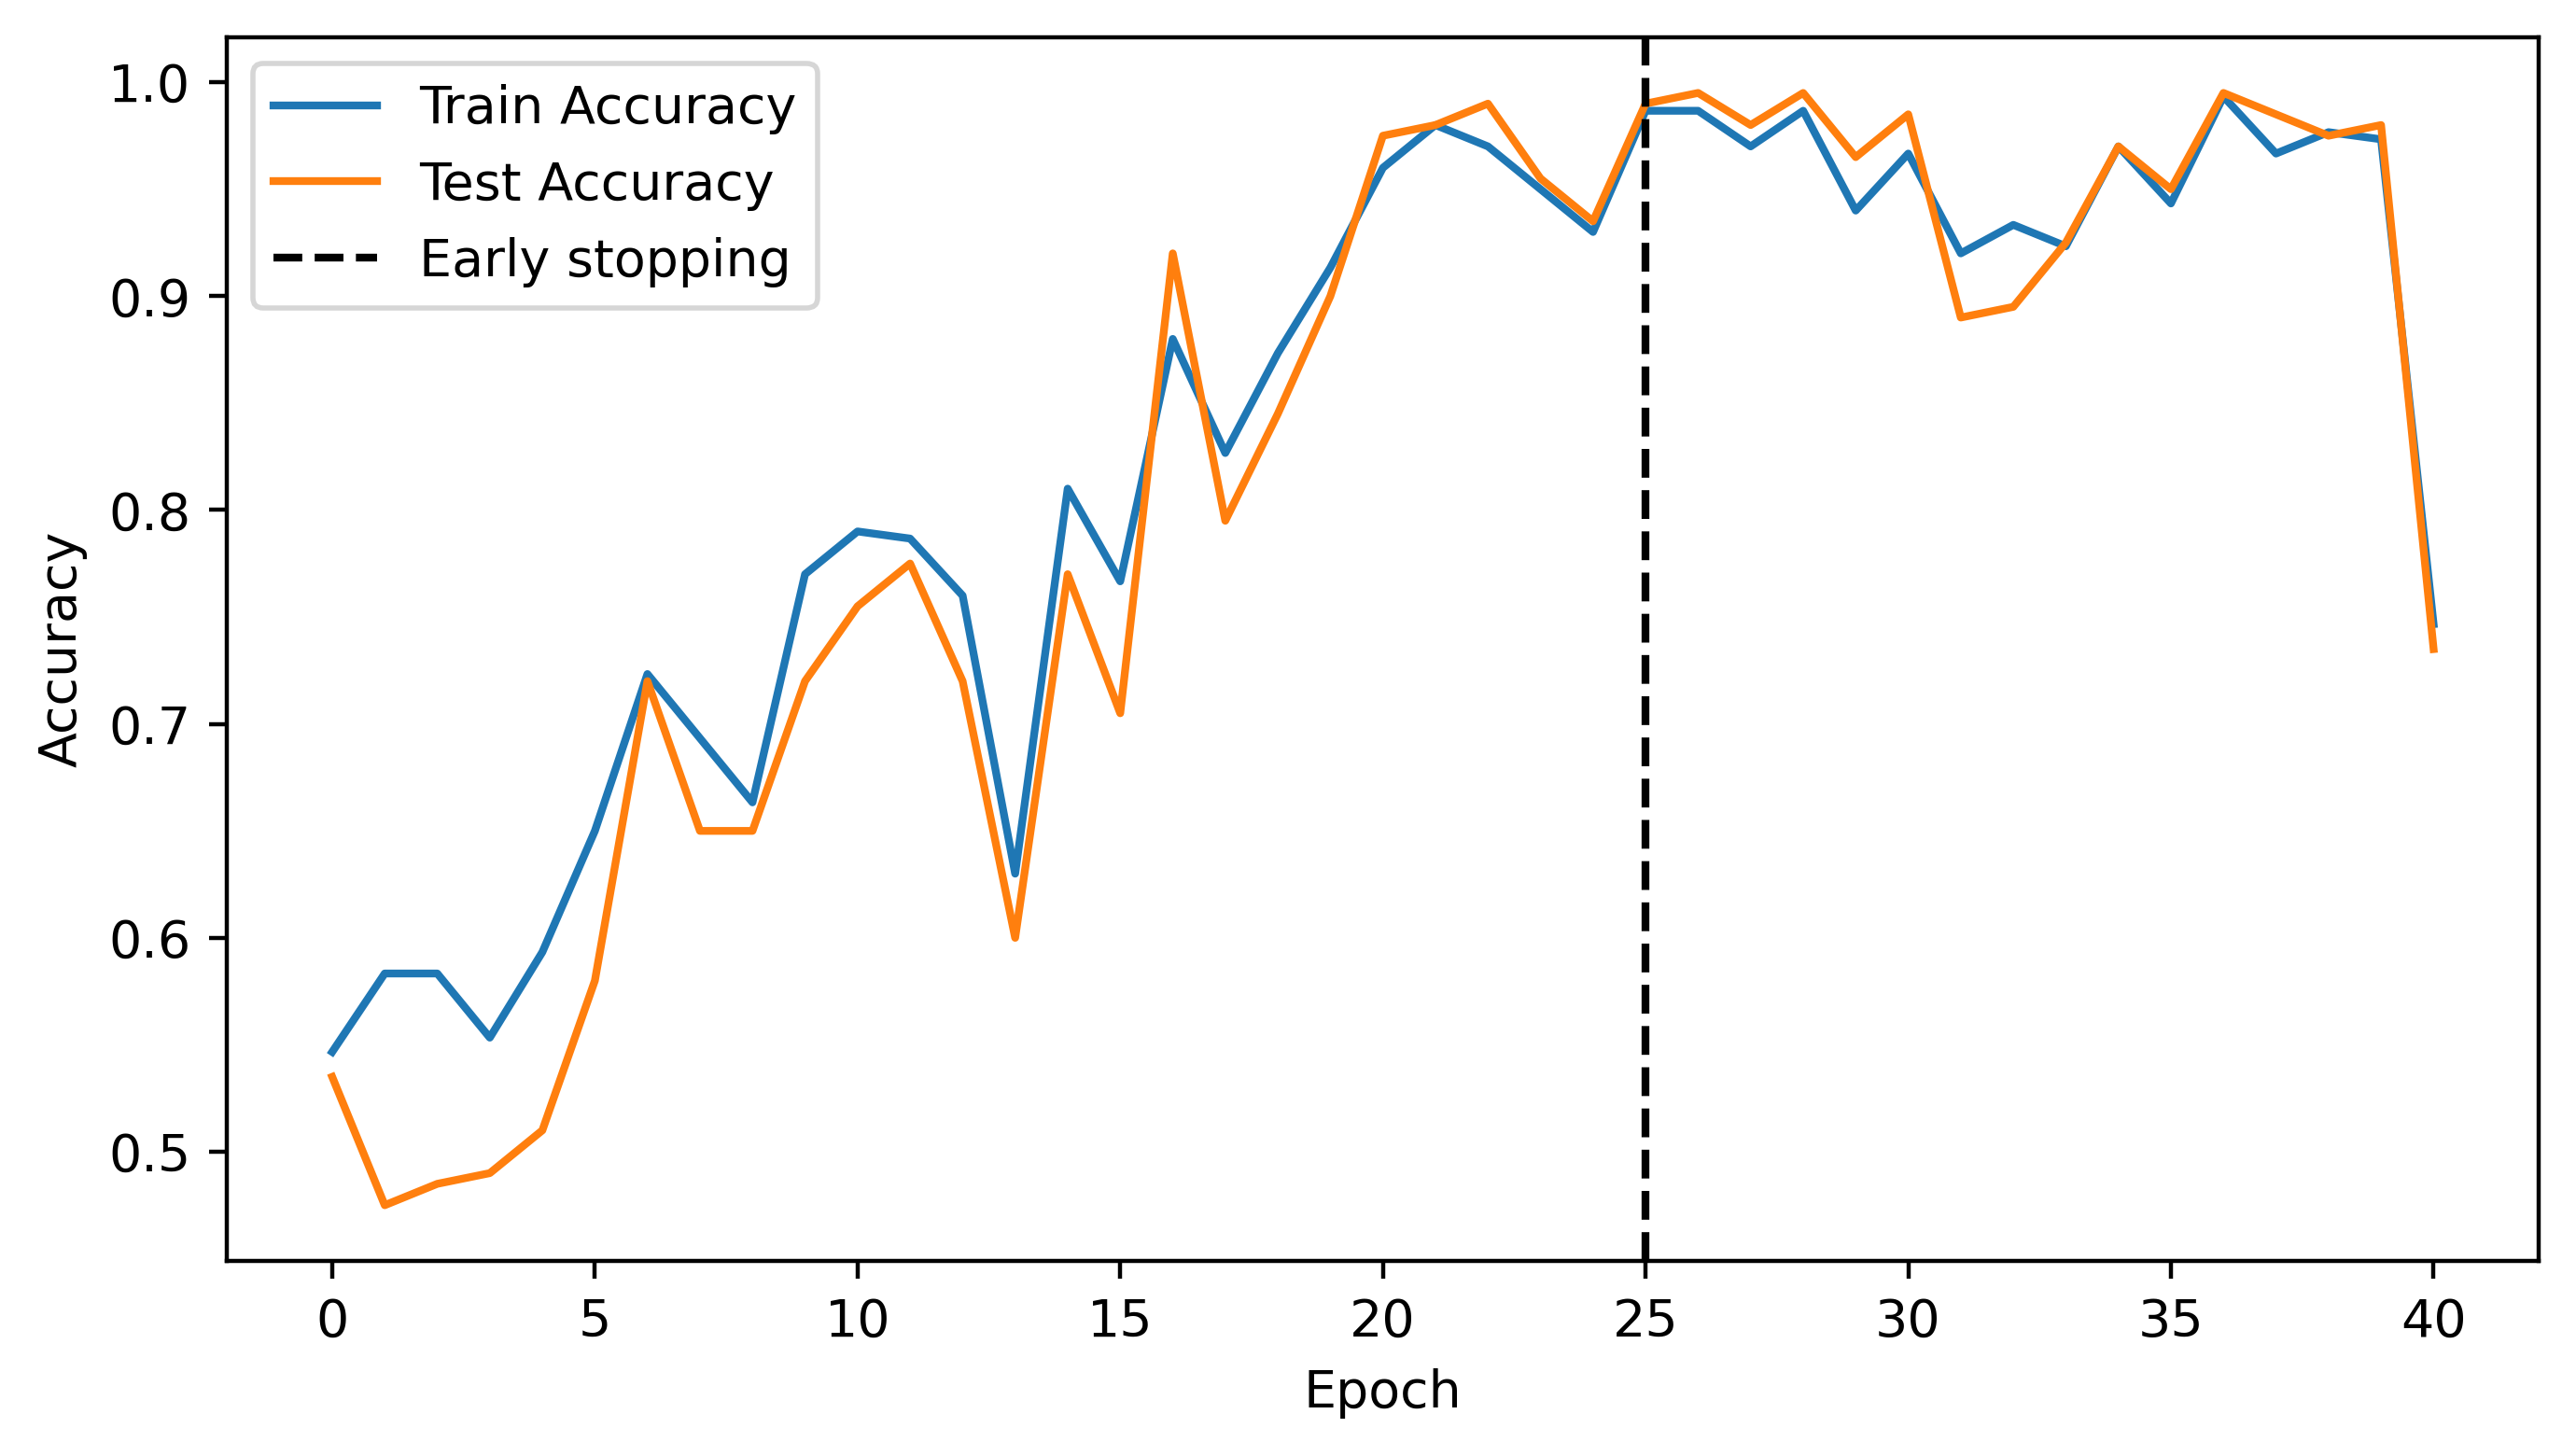

In [65]:
plt.figure(figsize=(7,4),dpi=400)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.axvline(stop_epoch,ls='--',color='black',label='Early stopping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('ClasificadorBinarioAcc.pdf')
plt.show()

In [66]:
# Función para evaluar una frase

def evaluar(frase):
    lista = [frase]

    raw_frase_diagram = reader.sentences2diagrams(lista)
    frase_diagram = [remove_cups(diagram) for diagram in raw_frase_diagram]
    frase_circuit = [ansatz(diagram) for diagram in frase_diagram]
    
    p_circ = frase_circuit[0].to_pennylane(probabilities=True)
    p_circ.initialise_concrete_params(model.symbols, model.weights)
    unnorm = p_circ.eval().detach().numpy()
    
    salida = unnorm / np.sum(unnorm)
    return [frase_diagram, frase_circuit,salida]

In [67]:
# frase positiva
frase = 'family enjoys impressive train .'

frase_diagram,frase_circuit,salida = evaluar(frase)
salida_pos = np.round(salida) # Se toma la salida de esta frase como referencia
print(salida)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.68853981 0.31146019]


In [68]:
# frase negativa
frase = 'student criticizes abandoned mine .'

frase_diagram,frase_circuit,salida = evaluar(frase)
print(salida)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.06422592 0.93577408]


In [69]:
# frases neutras
frase1 = 'student enters open museum .'
frase2 = 'tourist visits boring factory .'

frase_diagram,frase_circuit,salida1 = evaluar(frase1)
frase_diagram,frase_circuit,salida2 = evaluar(frase2)

print(salida1)
print(salida2)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.25876892 0.74123108]
[0.98766036 0.01233964]


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [70]:
# Matriz de confusión

from sklearn.metrics import confusion_matrix

data_ind = pd.read_csv('frases_individuales.csv',names=['frase','pol'])
y_true = data_ind['pol'].to_list()
y_pred = []
lista_frases = (data_ind['frase']+' .').to_list()
diagramas_frases_raw = reader.sentences2diagrams(lista_frases)
diagramas_frases = [remove_cups(diagram) for diagram in diagramas_frases_raw]
circuitos_frases = [ansatz(diagram) for diagram in diagramas_frases]
for i in range(len(circuitos_frases)):
    p_circ = circuitos_frases[i].to_pennylane(probabilities=True)
    p_circ.initialise_concrete_params(model.symbols, model.weights)
    unnorm = p_circ.eval().detach().numpy()
    salida = unnorm / np.sum(unnorm)
    salida = np.round(salida)
    if salida[0]==salida_pos[0] and salida[1]==salida_pos[1]:
        y_pred.append(1)
    else: y_pred.append(-1)

matriz_conf = confusion_matrix(y_true,y_pred)
print('Matriz de confusión (modelo cuántico):')
print(matriz_conf)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


Matriz de confusión (modelo cuántico):
[[100   0]
 [  1  99]]


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.06422592 0.93577408]


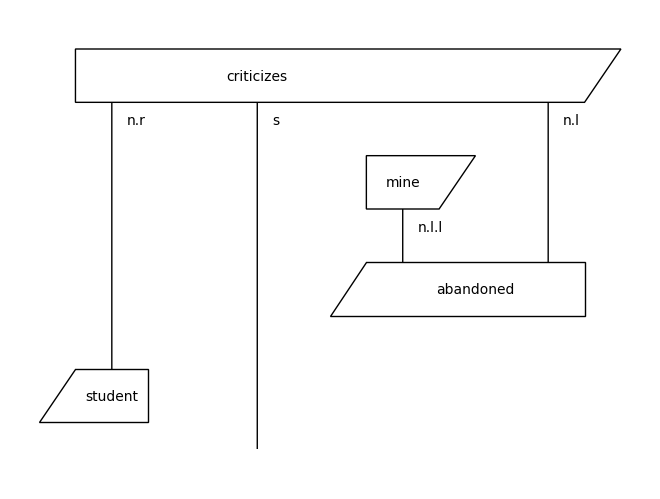

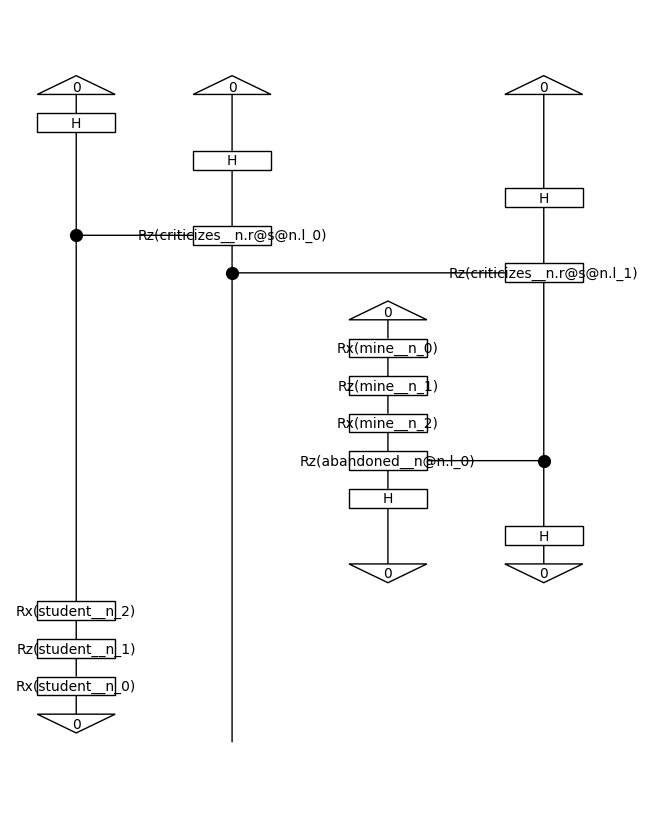

In [71]:
# frase cualquiera (muestra también el diagrama y el circuito)
frase = 'student criticizes abandoned mine .'

frase_diagram,frase_circuit,salida = evaluar(frase)
print(salida)

frase_diagram[0].draw()
frase_circuit[0].draw(figsize=(6, 8))

In [72]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = frase_circuit[0].to_tk()

render_circuit_jupyter(tket_circuit)

C:\Users\manue\anaconda3\envs\py39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


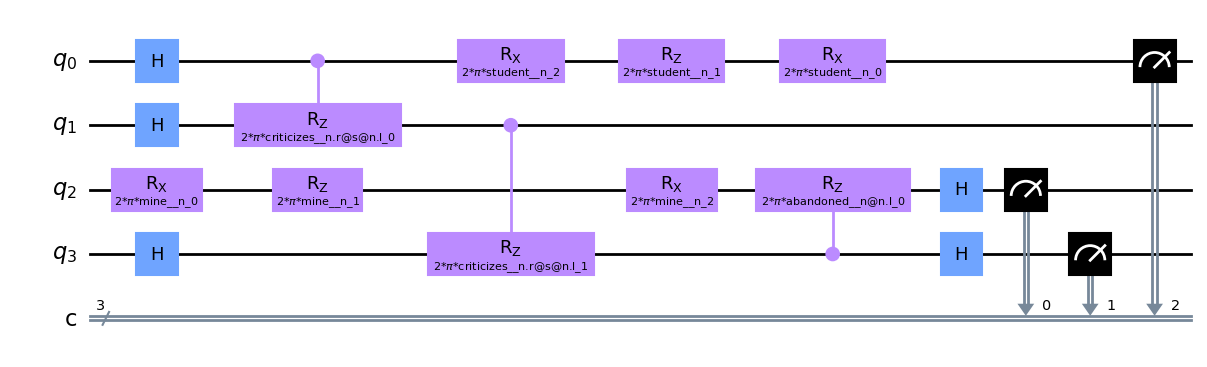

In [73]:
from pytket.extensions.qiskit import tk_to_qiskit

# Circuito en formato matplotlib
qiskit_circuit = tk_to_qiskit(tket_circuit)
qiskit_circuit.draw(output="mpl",)
#imagen = qiskit_circuit.draw(output="mpl")
#imagen.tight_layout()
#imagen.savefig('testtest.pdf')

In [74]:
# Circuito en formato LaTeX

qiskit_circuit = tk_to_qiskit(tket_circuit)
latex_circuit = qiskit_circuit.draw(output="latex_source")
latex_circuit = latex_circuit.replace('2*\pi','2\pi')
print(latex_circuit)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{H}} & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{2\pi*student__n_2})} & \gate{\mathrm{R_Z}\,(\mathrm{2\pi*student__n_1})} & \gate{\mathrm{R_X}\,(\mathrm{2\pi*student__n_0})} & \qw & \qw & \qw & \meter & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{H}} & \gate{\mathrm{R_Z}\,(\mathrm{2\pi*criticizes__n.r@s@n.l_0})} & \ctrl{2} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{R_X}\,(\mathrm{2\pi*mine__n_0})} & \gate{\mathrm{R_Z}\,(\mathrm{2\pi*mine__n_1})} & \qw & \gate{\mathrm{R_X}\,(\mathrm{2\pi*mine__n_2})} & \gate{\mathrm{R_Z}\,(\mathrm{2\pi*abandoned__n@n.l_0})} & \gate{\mathrm{H}} & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{3} :  } & \lstick{{q}_{3} :  } & \gate

C:\Users\manue\anaconda3\envs\py39\lib\site-packages\qiskit\visualization\circuit\latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


In [75]:
### MODELO CLÁSICO (RandomForest) ###
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('frases_individuales.csv',names=['frase','pol'])

x = df['frase']
y = df['pol']

vectorizer = CountVectorizer()
x_vec = vectorizer.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_vec, y, test_size=0.3, random_state=42)

model_c = RandomForestClassifier(n_estimators=100, random_state=42)
tstart=timer()
model_c.fit(x_train, y_train)
tend=timer()

y_pred = model_c.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:',accuracy)
print('Tiempo de entrenamiento:',tend-tstart,'segundos.')

y_pred = model_c.predict(x_vec)
y_true = y.to_list()
matriz_conf = confusion_matrix(y_true,y_pred)
print('Matriz de confusión (modelo clásico):')
print(matriz_conf)

frases_eval = ['family enjoys impressive train','student criticizes abandoned mine','student enters open museum','tourist visits boring factory']
for f in frases_eval:
    frase_vec = vectorizer.transform([f])
    frase_pred = model_c.predict(frase_vec)
    print(f,':',frase_pred[0])

Accuracy: 1.0
Tiempo de entrenamiento: 0.0913249000000178 segundos.
Matriz de confusión (modelo clásico):
[[100   0]
 [  0 100]]
family enjoys impressive train : 1
student criticizes abandoned mine : -1
student enters open museum : -1
tourist visits boring factory : 1
